# Import thư viện

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import requests
import numpy as np
import pandas as pd
import time # để sleep chương trình
from bs4 import BeautifulSoup
from pyvi import ViTokenizer # thư viện NLP tiếng Việt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
#Mô hình phân lớp
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import logging
import math

---

# Đọc dữ liệu

Hàm `ngram_word` ở bên dưới có input:
- `articles`: là một dictionary với key là chủ đề bài báo, value: là một list nội dung các bài báo trong chủ đề đó.

Output: Trả về biến `articles` sau khi đã tách các từ trong văn bản

In [2]:
def ngram_word(df):
    for i in range(len(df['Nội dung văn bản'])):
        df['Nội dung văn bản'][i] =  ViTokenizer.tokenize(df['Nội dung văn bản'][i])
    return df

Đầu tiên ta sẽ lấy dữ liệu đã thu thập được từ file `data.csv`

In [3]:
data_df = pd.read_csv('data.txt')
# temp = data_df[(data_df["Chủ đề"] != "kinh-doanh") & ((data_df["Chủ đề"] != "the-gioi"))]
# temp.to_csv("data.txt", index= False)

In [4]:
data_df

,Nội dung văn bản,Chủ đề
0,Bắn thuốc mê di dời đàn khỉ trong khu dân cư...,thoi-su
1,Lớp học bằng ván gỗ cũ nát ở vùng cao Lạng S...,thoi-su
2,,thoi-su
3,Sài Gòn xuống 19 độ C Ảnh hưởng không khí lạ...,thoi-su
4,,thoi-su
...,...,...
1832,Lễ hội áo dài sắp diễn ra bên bờ sông Hương ...,du-lich
1833,Trên máy bay không phải chỗ nào cũng cho trẻ...,du-lich
1834,Cắm trại đón Giáng sinh trong sân bay Singap...,du-lich
1835,Saigontourist Group khuyến mại lớn dịp Giáng...,du-lich


---

# Khám phá dữ liệu

In [5]:
data_df.head()

,Nội dung văn bản,Chủ đề
0,Bắn thuốc mê di dời đàn khỉ trong khu dân cư...,thoi-su
1,Lớp học bằng ván gỗ cũ nát ở vùng cao Lạng S...,thoi-su
2,,thoi-su
3,Sài Gòn xuống 19 độ C Ảnh hưởng không khí lạ...,thoi-su
4,,thoi-su


- Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [6]:
data_df.shape

(1837, 2)

- Dữ liệu có các dòng bị lặp không?

In [7]:
data_df.index.duplicated().sum()

0

- Kiểu dữ liệu của các cột

In [8]:
data_df.dtypes

Nội dung văn bản    object
Chủ đề              object
dtype: object

- Có dòng nào không lấy được nội dung văn bản không?

In [9]:
data_df['Nội dung văn bản'].isna().sum()

0

- Cột output có giá trị thiếu không?

In [10]:
data_df['Chủ đề'].isna().sum()

0

- Tỉ lệ các lớp trong cột output?

Text(0, 0.5, 'Percent (%)')

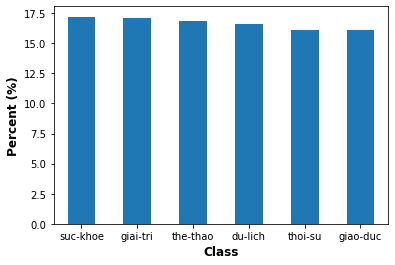

In [11]:
percent_class = data_df['Chủ đề'].value_counts(normalize=True) * 100
percent_class.plot.bar(rot=0)
plt.xlabel('Class', fontsize=12, weight='bold')
plt.ylabel('Percent (%)', fontsize=12, weight='bold')

Nhận xét: Tập dữ liệu phân bố khá đều.

---

# Tiền xử lý dữ liệu, xây dựng mô hình Markov ẩn

- thực hiện gôm các từ trong dữ liệu bằng hàm `ngram_word` tương tự như ở trên

In [12]:
data_df = ngram_word(data_df)
data_df

,Nội dung văn bản,Chủ đề
0,Bắn thuốc_mê di_dời đàn khỉ trong khu dân_cư S...,thoi-su
1,Lớp_học bằng ván gỗ cũ nát ở vùng_cao Lạng Sơn...,thoi-su
2,,thoi-su
3,Sài_Gòn xuống 19 độ C Ảnh_hưởng không_khí lạnh...,thoi-su
4,,thoi-su
...,...,...
1832,Lễ_hội áo_dài sắp diễn ra bên bờ sông Hương Th...,du-lich
1833,Trên máy_bay không phải chỗ nào cũng cho trẻ_e...,du-lich
1834,Cắm trại đón Giáng_sinh trong sân_bay Singapor...,du-lich
1835,Saigontourist_Group khuyến_mại lớn dịp Giáng_s...,du-lich


- Xóa đi những dòng có số kí tự ít hơn 100 (Có thể có những dòng không lấy được dữ liệu vì không giống định dạng mẫu)

In [13]:
data_df.drop(data_df[data_df['Nội dung văn bản'].map(len) < 1000].index, inplace = True)
#Dữ liệu sau khi xóa.
data_df.shape

(1475, 2)

- Ta sẽ chuyển cột Output `Chủ đề` thành dạng số

In [14]:
encoder = LabelEncoder()
data_df['Chủ đề'] = encoder.fit_transform(data_df['Chủ đề'])
data_df

,Nội dung văn bản,Chủ đề
0,Bắn thuốc_mê di_dời đàn khỉ trong khu dân_cư S...,5
1,Lớp_học bằng ván gỗ cũ nát ở vùng_cao Lạng Sơn...,5
3,Sài_Gòn xuống 19 độ C Ảnh_hưởng không_khí lạnh...,5
5,Ông lão 72 tuổi vào đại_học TP HCMÔng Nguyễn V...,5
6,Hơn 1 000 gia_súc chết rét 1 080 con trâu_bò d...,5
...,...,...
1829,UNESCO công_nhận văn_hóa bán hàng rong là di_s...,0
1831,Vẻ đẹp nguyên_sơ của Hồ Tràm Bà_Rịa Vũng TàuCu...,0
1832,Lễ_hội áo_dài sắp diễn ra bên bờ sông Hương Th...,0
1835,Saigontourist_Group khuyến_mại lớn dịp Giáng_s...,0


---

## Tách dữ liệu

In [15]:
X_df = data_df['Nội dung văn bản']
y_df = data_df['Chủ đề']
#Tách dữ liệu thành tập train và tập test

In [16]:
y_df.shape

(1475,)

In [17]:
#X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.3,stratify = y_df, random_state=0)
X_train = X_df
y_train = y_df

In [18]:
X_train

0       Bắn thuốc_mê di_dời đàn khỉ trong khu dân_cư S...
1       Lớp_học bằng ván gỗ cũ nát ở vùng_cao Lạng Sơn...
3       Sài_Gòn xuống 19 độ C Ảnh_hưởng không_khí lạnh...
5       Ông lão 72 tuổi vào đại_học TP HCMÔng Nguyễn V...
6       Hơn 1 000 gia_súc chết rét 1 080 con trâu_bò d...
                              ...                        
1829    UNESCO công_nhận văn_hóa bán hàng rong là di_s...
1831    Vẻ đẹp nguyên_sơ của Hồ Tràm Bà_Rịa Vũng TàuCu...
1832    Lễ_hội áo_dài sắp diễn ra bên bờ sông Hương Th...
1835    Saigontourist_Group khuyến_mại lớn dịp Giáng_s...
1836    Lợi_ích khi là khách_hàng thân_thiết của công_...
Name: Nội dung văn bản, Length: 1475, dtype: object

In [19]:
y_train

0       5
1       5
3       5
5       5
6       5
       ..
1829    0
1831    0
1832    0
1835    0
1836    0
Name: Chủ đề, Length: 1475, dtype: int32

## Xóa đi những từ quá đặc biệt và những từ xuất hiện nhiều ở các văn bản.

In [20]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf.fit_transform(data_df['Nội dung văn bản'])
feature_names = tfidf.get_feature_names()
document_vector=tfidf.idf_

#print the scores 
word_df = pd.DataFrame(document_vector, index=feature_names, columns=["IDF"])
word_df.sort_values(by=["IDF"],ascending=False)

,IDF
mâynhững,7.603944
stock,7.603944
liênbệnh,7.603944
liên_ấp,7.603944
liên_đội_trưởng,7.603944
...,...
là,1.088491
cho,1.083323
của,1.055725
trong,1.050723


In [21]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=8, max_df=0.45)
tfidf.fit_transform(data_df['Nội dung văn bản'])
feature_names = tfidf.get_feature_names()

document_vector=tfidf.idf_

#print the scores 
word_df = pd.DataFrame(document_vector, index=feature_names, columns=["IDF"])
word_df.sort_values(by=["IDF"],ascending=False)

,IDF
chọn_lựa,6.099866
nhảy_múa,6.099866
bình_tân,6.099866
bình_thạnh,6.099866
như_ý,6.099866
...,...
đầu,1.829392
cao,1.821658
gần,1.818581
2020,1.817046


Nhận xét:

## Xây dựng class Preprocessing  và mô hình Markov ẩn

In [22]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, min_df, max_df, word_df):
        self.min_df = min_df
        self.max_df = max_df
        self.word_df = word_df
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        new_df = X_df.copy()
        new_df = new_df.str.split(" ")
        for i in new_df.index:
            new_df[i] = [word.lower() for word in new_df[i] if word in self.word_df]
        return new_df

In [23]:
class HMM(ClassifierMixin):
    def __init__(self, description, state_list, obser_list):
        self.description = description

        self.N = len(state_list)
        self.M = len(obser_list)
        self.S = state_list
        self.O = obser_list
        
        tmp = list(range(self.N))  # Temporary array for states
        for i in range(self.N):
            tmp[i] = 0.0
    
        self.A = []
        for i in range(self.N):  # One line per state
            self.A.append(tmp[:])
            
        self.pi = tmp[:]
        
        tmp = list(range(self.M))  # Temporary array for observations
        for i in range(self.M):
            tmp[i] = 0.0

        # Matrix for observation probabilities  - - - - - - - - - - - - - - - - - -
        #
        self.B = []
        for i in range(self.N):  # One line per state
            self.B.append(tmp[:])
            
        self.S_ind = {}
        for i in range(self.N):
            self.S_ind[self.S[i]] = i
        self.O_ind = {}
        for i in range(self.M):
            self.O_ind[self.O[i]] = i

        # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        logging.info('Initialised HMM:')
        logging.info('  Description:  %s' % (self.description))
        logging.info('  States:       %s' % (str(state_list)))
        logging.info('  Observations: %s' % (str(obser_list)))
        
    def check_prob(self):
        """Check probabilities in HMM for validity.

        USAGE:
          myhmm.check_prob()

        ARGUMENTS:
          None

        DESCRIPTION:
          Checks all probabilities in the HMM for validity, i.e. if they sum to
          1.0 in each state (observation and outgoing state probabilities).

          If an error occurs, a negative number is returned, 0 otherwise
        """

        delta = 0.0000000000001  # Account for floating-point rounding errors
        ret = 0
        sum = 0.0
        for i in range(self.N):
            sum = sum+self.pi[i]
        if (abs(sum - 1.0) > delta):
            logging.warn('HMM initial state probabilities sum is not 1: %f' % (sum))
            ret -= 1
        for i in range(self.N):
            sum  = 0.0
            for j in range(self.N):
                sum = sum+self.A[i][j]
            if (abs(sum - 1.0) > delta):
                logging.warn('HMM state "%s" has transition ' % (self.S[i])  + \
                         'probabilities sum not 1.0: %f' % (sum))
                ret -= 1

        for i in range(self.N):
            sum  = 0
            for j in range(self.M):
                sum = sum+self.B[i][j]
            if (abs(sum - 1.0) > delta):
                logging.warn('HMM state "%s" has observation ' % (self.S[i]) + \
                         'probabilities sum not 1.0: '+str(sum))
                ret -= 1
        return ret

    def fit(self, X=None, y=None):
        """Train the HMM with annotated training data (supervised learning).

        USAGE:
          myhmm.train(train_data)

        ARGUMENTS:
          train_data  A set of training data in list form
          smoothing   If smoothing of the observation probabilities is desired (for
                      unknown symbols) then ths argument should be set to either
                      'laplace' (for Laplace smoothing) or 'absdiscount' (for the
                      absolute discounting method).
                      The default is 'None' and no smoothing will be done.

        DESCRIPTION:
          Using the training data, the HMM probabilities are set.

          'train_data' is a Python list with one element per training record.
          Each training record is a list (sequence) with pairs (tuple or list)
          of (state,observation) pairs. These training records can have varying
          length.

          For more information on the smoothing methods, see e.g.
            V.Borkar et.al., Automatic Segmentation of Text into
                             Structured Records
            Section 2.2
        """

        # Reset initial state, transition and observation probabilities - - - - - -
        #
        train_data = []
        for i in X.index:
            row = []
            for word in X[i]:
                row.append((y[i], word))
            train_data.append(row)
            
        for i in range(self.N):
            self.pi[i] = 0.0
            for j in range(self.N):
                self.A[i][j] = 0.0
            for j in range(self.M):
                self.B[i][j] = 0.0

        # Sum up probabilities from training data - - - - - - - - - - - - - - - - -
        #
        for train_rec in train_data:
            (init_state, init_obser) = train_rec[0]  # Get first tuple
            i = self.S_ind[init_state]
            self.pi[i] = self.pi[i] + 1.0

            for pair in train_rec:  # For each pair in this training record
                (state,obser) = pair
                i = self.S_ind[state]
                j = self.O_ind[obser]
                self.B[i][j] = self.B[i][j] + 1.0


        # Scale counts into probabilities - - - - - - - - - - - - - - - - - - - - -
        #
        # Scale initial probabilities
        #
        sum = 0.0
        for i in range(self.N):
            sum = sum+self.pi[i]
        if (sum != 0.0):
            for i in range(self.N):
                self.pi[i] = self.pi[i] / sum

        # Scale observation probabilities
        #
        # Do Laplace smoothing
        for i in range(self.N):  # For each state
            sum  = float(self.M)
            for j in range(self.M):
                sum = sum+self.B[i][j]
            for j in range(self.M):
                self.B[i][j] = (self.B[i][j]+1.0) / sum
        ###
        ###
        ###
        for train_rec in train_data:
            for i in range(len(train_rec)-1):
                word = train_rec[i][1]
                next_word = train_rec[i+1][1]
                for word_state in range(self.N):
                    prob_word_state = self.B[word_state][self.O_ind[word]]
                    for next_word_state in range(self.N):         
                        prob_next_word_state = self.B[next_word_state][self.O_ind[next_word]]
                        self.A[word_state][next_word_state] += prob_word_state * prob_next_word_state

        # Scale transition probabilities
        #
        for i in range(self.N):  # For each state
            sum  = 0.0
            for j in range(self.N):
                sum = sum+self.A[i][j]
            if (sum != 0.0):
                for j in range(self.N):
                    self.A[i][j] = self.A[i][j] / sum

        self.check_prob()  # Check if probabilities are OK

        # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        logging.info('Trained HMM with %i training records' % (len(X)))
        
    def viterbi(self, obser_seq):
        """Apply the Viterbi algorithm.

        USAGE:
          [sequence, seq_prob] = myhmm.viterbi(obser_seq)

        ARGUMENTS:
          obser_seq  An observation sequence (all observations must be in the list
                     of observations of the HMM)

        DESCRIPTION:
          This routine uses the Viterbi algorithm to find the most likely state
          sequence for the given observation sequence. Returns the sequence in a
          list and it's probability.
        """
    
        for obs in obser_seq:
            if obs not in self.O:
                self.O.append(obs)
                self.O_ind[obs] = self.M   
                for i in range(self.N):  # For each state
                    for j in range(self.M):
                        self.B[i][j] = self.B[i][j]*self.M/(self.M + 1)
                    self.B[i].append(1/(self.M + 1))

                self.M = self.M + 1

        tmp = list(range(self.N))  # Temporary array with zeros
        for i in range(self.N):
            tmp[i] = 0

        obs_len = len(obser_seq)
        obs_ind = []
        for obs in obser_seq:
            obs_ind.append(self.O_ind[obs])

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.N):
            delta[0][i] = self.pi[i] * self.B[i][obs_ind[0]]

        phi = [tmp[:]]

        for obs in obs_ind[1:]:  # For all observations except the inital one
            delta_t = tmp[:]
            phi_t = tmp[:]
            for j in range(self.N):   # Following formula 33 in Rabiner'89
                tdelta = tmp[:]
                tphimax = -1.0
                for i in range(self.N):
                    tphi_tmp = delta[-1][i] * self.A[i][j]
                    if (tphi_tmp > tphimax):
                        tphimax = tphi_tmp
                        phi_t[j] = i
                    tdelta[i] = tphi_tmp * self.B[j][obs]
                delta_t[j] = max(tdelta)
            if max(delta_t) < 0.001:
                mu = int(math.log(max(delta_t), 10))
                for i in range(self.N):
                    delta_t[i] = delta_t[i]/(10**mu)
            delta.append(delta_t)
            phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        #
        tmax = -1.0
        for i in range(self.N):
            if (delta[-1][i] > tmax):
                tmax = delta[-1][i]
                state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
            state_seq.append(tphi[state_seq[-1]])

        sequence = []

        for state in state_seq:
            sequence.append(self.S[state])

        sequence.reverse()  # Reverse into correct time direction
        state_seq.reverse()

        # Finally compute probability of this state and observation sequence
        #
        prev_ind = state_seq[0]
        seq_prob = self.pi[prev_ind]
        seq_prob *= self.B[prev_ind][self.O_ind[obser_seq[0]]]

        for i in range(1,len(state_seq)):
            ind = state_seq[i]
            obs = self.O_ind[obser_seq[i]]
            seq_prob *= self.A[prev_ind][ind]
            seq_prob *= self.B[ind][obs]
            prev_ind = ind

        # A log message - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #
        logging.debug('  Viterbi analysis')
        logging.debug('    Input observation sequence: %s' % (str(obser_seq)))
        logging.debug('    Output state sequence:      %s' % (str(sequence)))
        logging.debug('    Output probability: %f' % (seq_prob))

        return [sequence, seq_prob]

    def majority_role(self, state_sequence):
        count_state = {}
        for state in state_sequence:
            count_state[state] = count_state.get(state, 0) + 1
        #print(count_state)
        return max(count_state, key=count_state.get)
    
    def predict(self, X):
        predict_y_sr = []
        for test_rec in X:
            [state_sequence, sequence_probability] = self.viterbi(test_rec)
            #print(state_sequence)
            predict_y_sr.append(self.majority_role(state_sequence))
        return predict_y_sr

# Chạy mô hình và thử nghiệm trên tập test

## Chạy mô hình

In [24]:
hidden_states = list(y_train.unique())
hidden_states.sort()
hidden_states

[0, 1, 2, 3, 4, 5]

In [25]:
observation_states = word_df.index

- Tạo Pipeline

In [26]:
pipeline = Pipeline([('process',Preprocessing(min_df =10, max_df = 0.5, word_df = word_df.index)),
                     ('classifier',HMM("HMM model", hidden_states, observation_states))])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('process',
                 Preprocessing(max_df=0.5, min_df=10,
                               word_df=Index(['000', '01', '0h', '10', '100', '102', '103', '108', '1088', '109',
       ...
       'ủng_hộ', 'ủy', 'ủy_ban', 'ủy_viên', 'ức_chế', 'ứng_cử_viên',
       'ứng_dụng', 'ứng_phó', 'ứng_viên', 'ứng_xử'],
      dtype='object', length=5031))),
                ('classifier', <__main__.HMM object at 0x000002548EF1C910>)])

## Dự đoán trên tập Test

Đầu tiên ta lấy dữ liệu tập test đã thu thập được từ file `test.csv`

In [28]:
data_test_df = pd.read_csv('test.txt')
data_test_df

,Nội dung văn bản,Chủ đề
0,Công_an huyện Thanh_Trì Hà_Nội hôm_nay 15 1 ch...,thoi-su
1,Lắp_đặt hệ_thống điện mặt_trời áp mái để phục_...,thoi-su
2,“ Trong mọi trường_hợp người Việt_Nam nhập_cản...,thoi-su
3,Công_an thị_xã Sa_Pa Lào_Cai đang làm rõ nam t...,thoi-su
4,Bị_can Nguyễn Thành Mỹ đồng_phạm với ông Lê_Tấ...,thoi-su
...,...,...
516,Làng Tiebele trở_thành địa_điểm du_lịch hấp_dẫ...,du-lich
517,Mới_đây công_trình này bị liệt trong danh_sách...,du-lich
518,Ở tuổi 14 bạn_bè và gia_đình Nikhil Kamath có_...,du-lich
519,“ Tôi thực_sự thích làm những việc bình_thường...,du-lich


Sau đó ta thực hiện gôm các từ trong dữ liệu bằng hàm `ngram_word` tương tự như ở trên

In [29]:
data_test_df = ngram_word(data_test_df)
data_test_df

,Nội dung văn bản,Chủ đề
0,Công_an huyện Thanh_Trì Hà_Nội hôm_nay 15 1 ch...,thoi-su
1,Lắp_đặt hệ_thống điện mặt_trời áp mái để phục_...,thoi-su
2,“ Trong mọi trường_hợp người Việt_Nam nhập_cản...,thoi-su
3,Công_an thị_xã Sa_Pa Lào_Cai đang làm rõ nam t...,thoi-su
4,Bị_can Nguyễn Thành Mỹ đồng_phạm với ông Lê_Tấ...,thoi-su
...,...,...
516,Làng Tiebele trở_thành địa_điểm du_lịch hấp_dẫ...,du-lich
517,Mới_đây công_trình này bị liệt trong danh_sách...,du-lich
518,Ở tuổi 14 bạn_bè và gia_đình Nikhil Kamath có_...,du-lich
519,“ Tôi thực_sự thích làm những việc bình_thường...,du-lich


Xóa đi những dòng không lấy được dữ liệu

In [30]:
data_test_df.drop(data_test_df[data_test_df['Nội dung văn bản'].map(len) == 0].index, inplace = True)
data_test_df.shape

(521, 2)

Tách tập `Nội dung văn bản` và `Chủ đề` của tập Test để dự đoán và đánh giá

In [31]:
test_X_df = data_test_df['Nội dung văn bản']
test_y_df = data_test_df['Chủ đề']
test_y_df = encoder.transform(test_y_df)

Dự đoán chủ đề cho tập Test

In [32]:
predict_y_sr = pipeline.predict(test_X_df)

## Kết quả dự đoán

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

Confusion_Matrix = confusion_matrix(test_y_df, predict_y_sr)
Accuracy = accuracy_score(test_y_df, predict_y_sr)
F1 = f1_score(test_y_df, predict_y_sr, average='weighted')

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0, 1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


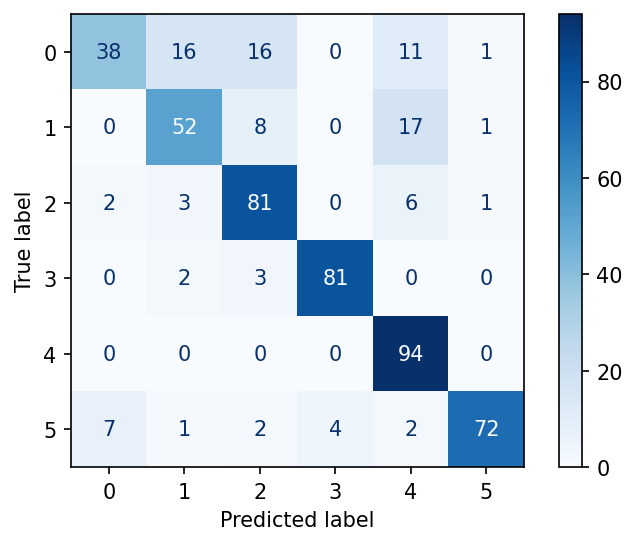

In [34]:
plt.figure(dpi=150)
axes = plt.axes()
cm_display = ConfusionMatrixDisplay(Confusion_Matrix, hidden_states).plot(cmap='Blues', ax = axes)

In [35]:
Accuracy

0.8023032629558541

In [36]:
F1

0.7946336276050121

# So sánh với mô hình NaiveBayes

## Xây dựng mô hình NaiveBayes

In [37]:
pipeline_NBC = Pipeline([('tfidf',TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_df=0.5, min_df=3)),
                     ('classifier',MultinomialNB(alpha=0.05))])

In [38]:
pipeline_NBC.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(2, 3))),
                ('classifier', MultinomialNB(alpha=0.05))])

In [39]:
predict_y_sr_NBC = pipeline_NBC.predict(test_X_df)

In [40]:
Confusion_Matrix_NBC = confusion_matrix(test_y_df, predict_y_sr_NBC)
Accuracy_NBC = accuracy_score(test_y_df, predict_y_sr_NBC)
F1_NBC = f1_score(test_y_df, predict_y_sr_NBC, average='weighted')

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[0, 1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


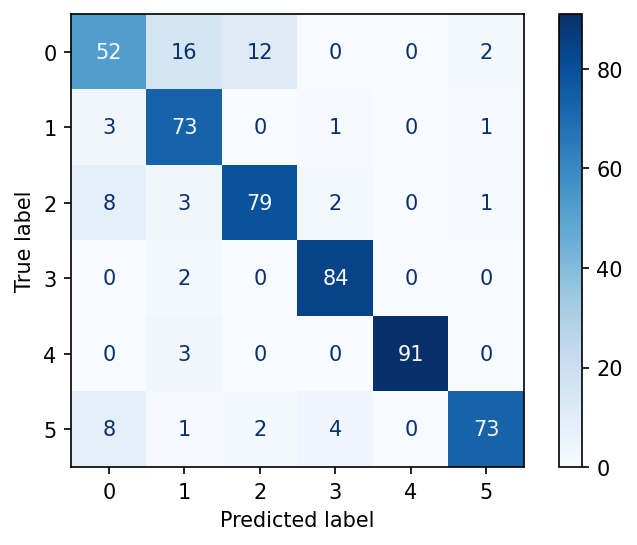

In [41]:
plt.figure(dpi=150)
axes = plt.axes()
cm_display = ConfusionMatrixDisplay(Confusion_Matrix_NBC, hidden_states).plot(cmap='Blues', ax = axes)

In [42]:
Accuracy_NBC

0.8675623800383877

In [43]:
F1_NBC

0.8664348724231457

## Nhận xét

Nhìn chung, mặc dù cùng dựa vào lý thuyết xác suất làm nền tảng để xây dựng mô hình, nhưng mô hình `Hidden Markov` cho kết quả phân lớp không tốt bằng mô hình `Naive Bayes Classification`. Không những vậy, `Hidden Markov Model` được xây dựng tương đối phức tạp, đòi hỏi chi phí thời gian và bộ nhớ lớn.